In [2]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

# from utils import read_trc, read_mot
# import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'Shared drives/OpencapNMD/Data'


In [3]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466"]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [4]:
df_session = pd.read_excel(datadir / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / 'participant_info.xlsx')

feats_path = Path('./feats.pkl')
df_feat = pd.read_pickle(feats_path)

survey_fpath = gdrive / datadir / 'DHD Data Export_6June2023.csv'
df_survey = pd.read_csv(survey_fpath, usecols=['open_id', 'activ_total'] + [f'activ_{i+1}' for i in range(22)])
df_survey['pid'] = df_survey.open_id.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_survey.drop(columns='open_id', inplace=True)
# df_survey = df_survey[['pid'] + list(df_survey.columns[:-1])]


In [5]:
feats = ['run_speed',
         'run_com_sway',
         'run_mean_ptp_hip_add',
         'run_mean_max_ka'
        ]
# feats = ['run_speed',
#          'brooke_max_min_sa',
#          'reachable_workspace',
#          'jump_max_com_vel',
#         ]

tfts = ['time_10mwrt']

df_temp = df_feat[['pid']+feats].dropna()
df_temp = df_temp.merge(df_survey[['activ_total', 'pid']], 'inner', 'pid')
df_temp = df_temp.merge(df_part[['pid', 'type']+ tfts], 'inner', 'pid')
df_temp = df_temp.dropna()
df_temp['is_nmd'] = df_temp.type != 'CTL'
df_temp['is_44'] = df_temp.activ_total == 44

df_temp


,pid,run_speed,run_com_sway,run_mean_ptp_hip_add,run_mean_max_ka,activ_total,type,time_10mwrt,is_nmd,is_44
0,p011,3.287671,0.030186,38.794547,89.399283,44.00,DM,3.75,True,True
1,p012,3.720930,0.011477,34.024481,126.306726,40.02,DM,2.91,True,False
2,p013,3.287671,0.047225,32.064921,112.114607,35.00,FSHD,4.35,True,False
3,p014,4.247788,0.021643,37.668599,78.442028,43.00,FSHD,2.75,True,False
4,p017,1.605351,0.041320,27.203589,68.628622,44.00,DM,7.09,True,True
...,...,...,...,...,...,...,...,...,...,...
87,p106,1.403509,0.128561,23.980553,61.386917,30.00,DM,8.01,True,False
88,p110,3.750000,0.062603,33.660691,95.570806,44.00,CTL,3.44,False,True
89,p111,4.705882,0.028452,33.848205,111.971770,44.00,CTL,2.88,False,True
90,p120,3.243243,0.037987,42.946476,103.861925,42.00,DM,3.71,True,False


In [6]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

clf = make_pipeline(StandardScaler(),
                    LinearSVC(dual="auto", random_state=0, tol=1e-5))

def cv_clf(data, feats, label, clf):
    pids = data.pid.unique()
    accs = []
    for i, holdout in enumerate(pids):
        is_train = data.pid != holdout
        is_test = data.pid == holdout

        X_train = data[feats][is_train].values
        y_train = data[label][is_train].values
        # y_train = df_temp.activ_total[is_train].values

        X_test = data[feats][is_test].values
        y_test = data[label][is_test].values
        # y_test = df_temp.activ_total[is_test].values

        clf.fit(X_train, y_train)
        # preds.append(clf.predict(X_test))
        accs.append(np.mean(clf.predict(X_test) == y_test))

    accs = np.array(accs)
    print(np.mean(accs))
    

cv_clf(df_temp, feats, 'type', clf)
cv_clf(df_temp, tfts, 'type', clf)

print()

cv_clf(df_temp, feats, 'is_nmd', clf)
cv_clf(df_temp, tfts, 'is_nmd', clf)

print()

cv_clf(df_temp[df_temp.is_nmd], feats, 'type', clf)
cv_clf(df_temp[df_temp.is_nmd], tfts, 'type', clf)

print()

cv_clf(df_temp[df_temp.is_nmd], feats, 'is_44', clf)
cv_clf(df_temp[df_temp.is_nmd], tfts, 'is_44', clf)


0.4883720930232558
0.5232558139534884

0.8023255813953488
0.7790697674418605

0.4
0.48

0.84
0.8


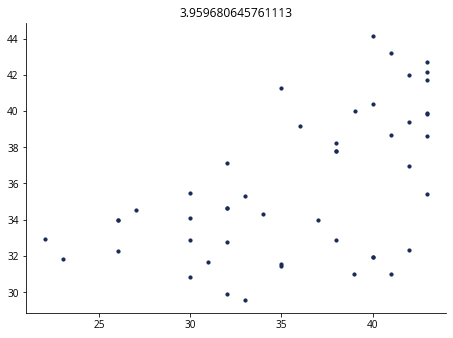

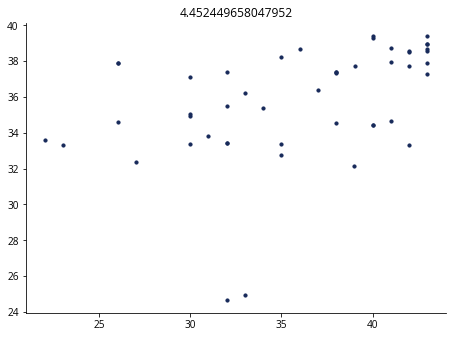

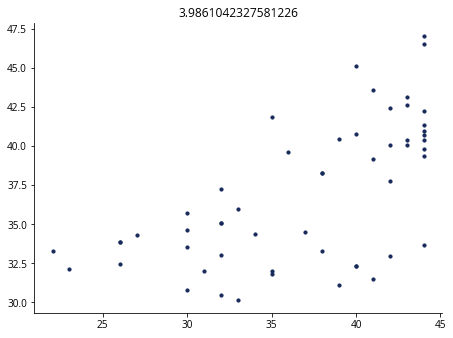

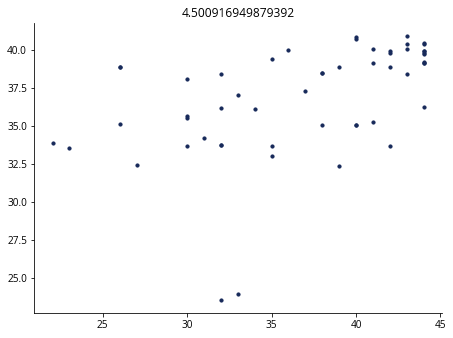

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()

def cv_regr(data, feats, label, model, show=True):
    pids = data.pid
    preds = []
    trues = []
    for i, holdout in enumerate(pids):
        is_train = data.pid != holdout
        is_test = data.pid == holdout

        X_train = data[feats][is_train].values
        y_train = data[label][is_train].values
        # y_train = df_temp.activ_total[is_train].values
        
        X_test = data[feats][is_test].values[:1,:]
        y_test = data[label][is_test].values[:1]
        # y_test = df_temp.activ_total[is_test].values

        model.fit(X_train, y_train)
        # preds.append(clf.predict(X_test))
        preds += list(model.predict(X_test))
        trues += list(y_test)
        
    mae = mean_absolute_error(trues, preds)
    if show:
        plt.scatter(trues, preds, s=10)
        plt.title(mae)
        plt.tight_layout()
        plt.show()
    return mae

cv_regr(df_temp[~df_temp.is_44], feats, 'activ_total', model)
cv_regr(df_temp[~df_temp.is_44], tfts, 'activ_total', model)

print()

cv_regr(df_temp[df_temp.is_nmd], feats, 'activ_total', model)
cv_regr(df_temp[df_temp.is_nmd], tfts, 'activ_total', model)

print()


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()

def bootstrapped_cv(data, feats, label, model, n_resamp=1e3):
    
    maes = []
    for i in trange(n_resamp):
        df_resamp = data.sample(len(data), replace=True)
        
        mae = cv_regr(df_resamp, feats, label, model, show=False)
        maes.append(mae)
    return maes
    
n_resamp = 100
oc_maes = bootstrapped_cv(df_temp[df_temp.is_nmd], feats, 'activ_total', model, n_resamp)
tft_maes = bootstrapped_cv(df_temp[df_temp.is_nmd], tfts, 'activ_total', model, n_resamp)



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

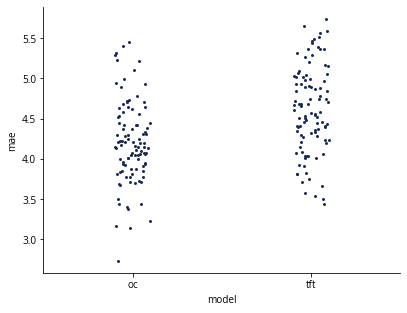

In [10]:
maes = []
for mae in oc_maes:
    maes.append({'model':'oc', 'mae':mae})
for mae in tft_maes:
    maes.append({'model':'tft', 'mae':mae})
df_mae = pd.DataFrame(maes)

sns.stripplot(data=df_mae, x='model', y='mae', s=3)
# plt.axhline(np.percentile(oc_maes, 2.5), c='r')
# plt.axhline(np.percentile(oc_maes, 97.5), c='r')
plt.show()


In [93]:
df_mae.groupby('model').quantile([0.025, 0.5, 0.975]).reset_index()


,model,level_1,mae
0,oc,0.025,3.145702
1,oc,0.500,4.093572
2,oc,0.975,5.302680
3,tft,0.025,3.611351
4,tft,0.500,4.634544
5,tft,0.975,5.591291


In [94]:
# df_mae.groupby('model').agg({
#     'ci_lo': lambda x: np.percentile(x, 2.5),
#     'ci_hi': lambda x: np.percentile(x, 97.5)})

def percentile(n):
    def percentile_(x):
        return x.quantile(n/100)
    percentile_.__name__ = 'pctl_{:02.1f}'.format(n)
    return percentile_

df_mae.groupby('model').agg([percentile(2.5), percentile(97.5)])
# ci_hi = df_mae.groupby('model').agg(lambda x: np.percentile(x, 97.5))


mae          
       pctl_2.5 pctl_97.5
model                    
oc     3.145702  5.302680
tft    3.611351  5.591291